# Autocorrect and Autocomplete

You use *auto-correct* everyday. When you send your friend a text message, or when you make a mistake in a query, there is an autocorrect behind the scenes that corrects the sentence for you. It based on minimum edit distance, which tells you the minimum amount of edits to change one word into another and also it involves dynamic programming methods which is an important programming concept and could be used to solve a lot of optimization problems.

**Autocorrect:**

<u>deah</u> -> dear 

How it works:
1. Identify a misspelled word. (*deah*)
2. Find string n edit distance away. (*_eah d_ar de_r* ... etc)
3. Filter candidates. (*yeah dear dean* ... etc)
4. Calculate probabilities. (how likely each word is to appear in this context)

# Import

In [3]:
import re                       # regular expression library; for tokenization of words
import matplotlib.pyplot as plt # for data visualization
from collections import Counter # collections library; counter: dict subclass for counting hashable objects
import pandas as pd
import numpy as np

C:\Users\maks1\AppData\Local\Temp\ipykernel_2300\376471819.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Way to identify a word:

Check is a word in the vocabulary or no, if it isn't there it's misspelled.

In [ ]:
if word not in vocabulary:
    misspelled = True

In [2]:
text = 'red pink pink blue blue yellow ORANGE BLUE BLUE PINK' # 🌈
print(text)
print('string length : ',len(text))

red pink pink blue blue yellow ORANGE BLUE BLUE PINK
string length :  52


In [3]:
# convert all letters to lower case
text_lowercase = text.lower()
print(text_lowercase)
print('string length : ',len(text_lowercase))

red pink pink blue blue yellow orange blue blue pink
string length :  52


In [4]:
# some regex to tokenize the string to words and return them in a list
words = re.findall(r'\w+', text_lowercase)
print(words)
print('count : ',len(words))

['red', 'pink', 'pink', 'blue', 'blue', 'yellow', 'orange', 'blue', 'blue', 'pink']
count :  10


In [5]:
# create vocab
vocab = set(words)
print(vocab)
print('count : ',len(vocab))

{'red', 'pink', 'yellow', 'orange', 'blue'}
count :  5


In [6]:
# create vocab including word count
counts_a = dict()
for w in words:
    counts_a[w] = counts_a.get(w,0)+1
print(counts_a)
print('count : ',len(counts_a))

{'red': 1, 'pink': 3, 'blue': 4, 'yellow': 1, 'orange': 1}
count :  5


In [7]:
# create vocab including word count using collections.Counter
counts_b = dict()
counts_b = Counter(words)
print(counts_b)
print('count : ',len(counts_b))

Counter({'blue': 4, 'pink': 3, 'red': 1, 'yellow': 1, 'orange': 1})
count :  5


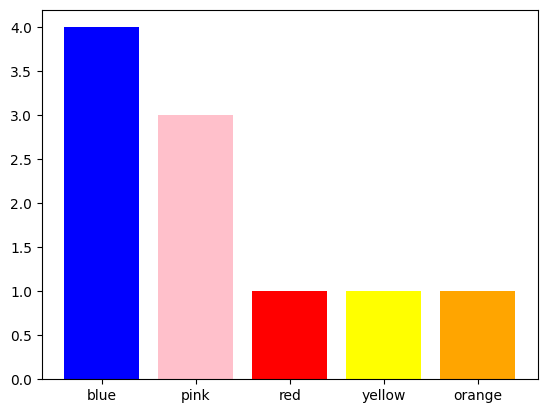

In [11]:
# barchart of sorted word counts
d = {'blue': counts_b['blue'], 'pink': counts_b['pink'], 'red': counts_b['red'], 'yellow': counts_b['yellow'], 'orange': counts_b['orange']}
plt.bar(range(len(d)), list(d.values()), align='center', color=d.keys())
_ = plt.xticks(range(len(d)), list(d.keys()))

## Ways to find a word:
1. Insert (add a letter) *'to': 'two', 'top' ...*
2. Delete (remove a letter) *'hat': 'ha', 'at', 'ht' ...*
3. Switch (swap 2 adjacent letters) *'eta': 'eat', 'tea' ...*
4. Replace (change 1 letter to another): *'jaw': 'jar', 'paw' ...*

In [1]:
# data
word = 'dearz' # 🦌

In [2]:
# Find all the ways you can split a word into 2 parts !
splits_a = []
for i in range(len(word)+1):
    splits_a.append([word[:i],word[i:]])

for i in splits_a:
    print(i)

['', 'dearz']
['d', 'earz']
['de', 'arz']
['dea', 'rz']
['dear', 'z']
['dearz', '']


In [3]:
# Delete a letter from each string in the splits list.
splits = splits_a
deletes = []

print('word : ', word)
for L,R in splits:
    if R:
        print(L + R[1:], ' <-- delete ', R[0])

word :  dearz
earz  <-- delete  d
darz  <-- delete  e
derz  <-- delete  a
deaz  <-- delete  r
dear  <-- delete  z


In [4]:
# It's worth taking a closer look at how this is excecuting a 'delete'.
print('word : ', word)
one_split = splits[0]
print('first item from the splits list : ', one_split)
L = one_split[0]
R = one_split[1]
print('L : ', L)
print('R : ', R)
print('*** now implicit delete by excluding the leading letter ***')
print('L + R[1:] : ',L + R[1:], ' <-- delete ', R[0])

word :  dearz
first item from the splits list :  ['', 'dearz']
L :  
R :  dearz
*** now implicit delete by excluding the leading letter ***
L + R[1:] :  earz  <-- delete  d


In [5]:
deletes = [L + R[1:] for L, R in splits if R]

print(deletes)
print('*** which is the same as ***')
for i in deletes:
    print(i)

['earz', 'darz', 'derz', 'deaz', 'dear']
*** which is the same as ***
earz
darz
derz
deaz
dear


In [7]:
# Next step will be to filter this list for candidate words found in a vocabulary.
vocab = ['dean','deer','dear','fries','and','coke']
edits = list(deletes)

print('vocab : ', vocab)
print('edits : ', edits)

candidates=[]

candidates = set.intersection(set(vocab), set(edits))

print('candidate words : ', candidates)

vocab :  ['dean', 'deer', 'dear', 'fries', 'and', 'coke']
edits :  ['earz', 'darz', 'derz', 'deaz', 'dear']
candidate words :  {'dear'}


## Way to filter candidates:

<u>deah</u> -----> <u>deah</u>

_eah -----> yeah

d_ar -----> dear

de_r -----> dean

...etc -----> ...etc

Minimum edit distance:

Source: play -> Target: stay

D[i,j] = source[:i] -> target[:j]

In [ ]:
# COST MATRIX
# # # 0 1 2 3 4
# # # # s t a y
# 0 # 0 1 2 3 4
# 1 p 1 2 3 4 5
# 2 l 2 3 4 5 6
# 3 a 3 4 5 4 5
# 4 y 4 5 6 5 4

# Once you get from p, l to s, d the suffix of both words is the same, a, y. 
# So there are no more edits needed. And that's why this 4 carries down the diagonal. 

# Source: play -> Target: stay
# [0,0] -> (# -> #)
# [1,0] -> (p -> #) delete
# [0,1] -> (# -> s) insert
# [1,1] -> (p -> s) 
#                  insert + delete: p -> ps -> s: 2
#                  delete + insert: p ->  # -> s: 2
#                  replace:         p -> s:       2

# play -> #
# D[i,j] = D[i-1,j] + delete_cost
# D[4,0] = play -> #
#        = source[:4] -> target[0]

# # -> play
# D[i,j] = D[i,j-1] + insert_cost

#### GENERAL ####
# D[i,j] = 
#
#     Г D[i-1,j] + delete_cost
# min | D[i,j-1] + insert_cost
#     L D[i-1,j-1] + Г replace_cost; if source[i] != target[j]
#                    L 0;            if source[i]  = target[j]

### Minimum edit distance
* **Levenshtein distance.** Measuring the edit distance by using the three edits; insert, delete, and replace with costs 1, 1 and 2 respectively. That's what you've used here. 
* **Backtrace.** There are also well-known alternatives that have difference at its rules. Finding the minimum edit distance on its own doesn't always solve the whole problem. You sometimes need to know how you got there too. You do this by keeping a backtrace, which is simply a pointer in each cell letting you know where you came from to get there so you know the path taken across the table from the top left corner to the bottom right corner. This tells you the edits taken and is particularly useful in problems dealing with string alignment. 
* **Dynamic programming.** Finally, this tabular method for computation instead of brute force, is a technique known as dynamic programming. Intuitively, this just means that solving the smallest subproblem first and then reusing that result to solve the next biggest subproblem, saving that result, reusing it again and so on. This is what you did here by solving each cell in order. 

## Way to calculate probabilities:

Probability_of_a_word = (Numbers_of_time_the_word_appears) / (Total_size_of_the_corpus)

In [13]:
senatance= 'Autocorrect is a powerful tool and it is used on our computer.'.split()
print(senatance)
print("P(is) = ", round(senatance.count('is') / len(senatance), 2))

['Autocorrect', 'is', 'a', 'powerful', 'tool', 'and', 'it', 'is', 'used', 'on', 'our', 'computer.']
P(is) =  0.17


# Autocorrect (full process)

### Process Data

In [4]:
def process_data(file_name):
    """
    Input: 
        A file_name which is found in your current directory. You just have to read it in. 
    Output: 
        words: a list containing all the words in the corpus (text file you read) in lower case. 
    """
    words = []

    # read file and convert into lower case
    with open(file_name, 'r') as text_file:
        raw_text = text_file.read().lower()
    
    # return as a list without special characters
    words = re.findall('\w+', raw_text)
    
    return words

In [36]:
word_l = process_data('D:\Learning_py\kaggle\Autocorrect-and-Autocomplete-NLP\input_data\shakespeare.txt')
vocab = set(word_l)
print(word_l[0:10])

['o', 'for', 'a', 'muse', 'of', 'fire', 'that', 'would', 'ascend', 'the']


### Get count of words

In [9]:
def get_count(word_l):
    '''
    Input:
        word_l: a set of words representing the corpus. 
    Output:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    '''
    word_count_dict = {}  # word counts
    
    for word in word_l:
        word_count_dict[word] = word_count_dict.get(word,0) + 1        
    
    return word_count_dict

In [10]:
word_count_dict = get_count(word_l)

### Get probabilities

In [11]:
def get_probs(word_count_dict):
    '''
    Input:
        word_count_dict: The wordcount dictionary where key is the word and value is its frequency.
    Output:
        probs: A dictionary where keys are the words and the values are the probability that a word will occur. 
    '''
    probs = {} 

    total = sum(word_count_dict.values())
    
    for key, val in word_count_dict.items():
        probs[key] = val / total
    
    return probs

In [12]:
probs = get_probs(word_count_dict)

## String Manipulations

### Delete letter

In [13]:
def delete_letter(word, verbose=False):
    '''
    Input:
        word: the string/word for which you will generate all possible words 
                in the vocabulary which have 1 missing character
    Output:
        delete_l: a list of all possible strings obtained by deleting 1 character from word
    '''
    
    delete_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    delete_l = [''.join([word[:i], word[(i+1):]]) for i in range(len(word))]
                                                   
    if verbose: print(f"input word {word}, \nsplit_l = {split_l}, \ndelete_l = {delete_l}")

    return  delete_l

In [15]:
delete_word_l = delete_letter(word="citrix", verbose=True)

input word citrix, 
split_l = [('', 'citrix'), ('c', 'itrix'), ('ci', 'trix'), ('cit', 'rix'), ('citr', 'ix'), ('citri', 'x')], 
delete_l = ['itrix', 'ctrix', 'cirix', 'citix', 'citrx', 'citri']


### Switch letter

In [16]:
def switch_letter(word, verbose=False):
    '''
    Input:
        word: input string
     Output:
        switches: a list of all possible strings with one adjacent charater switched
    ''' 
    
    switch_l = []
    split_l = []
    
    switch_l = [''.join([word[:i], word[i+1], word[i], word[(i+2):]]) for i in range(len(word)-1)]
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nswitch_l = {switch_l}") 
    
    return switch_l

In [17]:
switch_word_l = switch_letter(word="baeutiful", verbose=True)

Input word = baeutiful 
split_l = [('', 'baeutiful'), ('b', 'aeutiful'), ('ba', 'eutiful'), ('bae', 'utiful'), ('baeu', 'tiful'), ('baeut', 'iful'), ('baeuti', 'ful'), ('baeutif', 'ul'), ('baeutifu', 'l')] 
switch_l = ['abeutiful', 'beautiful', 'bauetiful', 'baetuiful', 'baeuitful', 'baeutfiul', 'baeutiufl', 'baeutiflu']


### Replace letter

In [18]:
def replace_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        replaces: a list of all possible strings where we replaced one letter from the original word. 
    ''' 
    
    letters = 'abcdefghijklmnopqrstuvwxyz'
    
    replace_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    
    replace_set = {''.join([word[:word_i], letter, word[(word_i+1):]])
                        for word_i in range(len(word))
                        for letter in letters}
    
    # turn the set back into a list and sort it, for easier viewing
    replace_l = sorted(list(replace_set - {word}))
    
    if verbose: print(f"Input word = {word} \nsplit_l = {split_l} \nreplace_l {replace_l}")   
    
    return replace_l

In [19]:
replace_l = replace_letter(word='can', verbose=True)

Input word = can 
split_l = [('', 'can'), ('c', 'an'), ('ca', 'n')] 
replace_l ['aan', 'ban', 'caa', 'cab', 'cac', 'cad', 'cae', 'caf', 'cag', 'cah', 'cai', 'caj', 'cak', 'cal', 'cam', 'cao', 'cap', 'caq', 'car', 'cas', 'cat', 'cau', 'cav', 'caw', 'cax', 'cay', 'caz', 'cbn', 'ccn', 'cdn', 'cen', 'cfn', 'cgn', 'chn', 'cin', 'cjn', 'ckn', 'cln', 'cmn', 'cnn', 'con', 'cpn', 'cqn', 'crn', 'csn', 'ctn', 'cun', 'cvn', 'cwn', 'cxn', 'cyn', 'czn', 'dan', 'ean', 'fan', 'gan', 'han', 'ian', 'jan', 'kan', 'lan', 'man', 'nan', 'oan', 'pan', 'qan', 'ran', 'san', 'tan', 'uan', 'van', 'wan', 'xan', 'yan', 'zan']


### Insert letter

In [20]:
def insert_letter(word, verbose=False):
    '''
    Input:
        word: the input string/word 
    Output:
        inserts: a set of all possible strings with one new letter inserted at every offset
    ''' 
    letters = 'abcdefghijklmnopqrstuvwxyz'
    insert_l = []
    split_l = []
    
    split_l = [(word[:i], word[i:]) for i in range(len(word))]
    insert_l = [''.join([word[:i], letter, word[i:]]) for i in range(len(word)+1) for letter in letters]
    
    if verbose: print(f"Input word {word} \nsplit_l = {split_l} \ninsert_l = {insert_l}")
    
    return insert_l

In [21]:
insert_l = insert_letter('in', True)
print(f"Number of strings output by insert_letter('at') is {len(insert_l)}")

Input word in 
split_l = [('', 'in'), ('i', 'n')] 
insert_l = ['ain', 'bin', 'cin', 'din', 'ein', 'fin', 'gin', 'hin', 'iin', 'jin', 'kin', 'lin', 'min', 'nin', 'oin', 'pin', 'qin', 'rin', 'sin', 'tin', 'uin', 'vin', 'win', 'xin', 'yin', 'zin', 'ian', 'ibn', 'icn', 'idn', 'ien', 'ifn', 'ign', 'ihn', 'iin', 'ijn', 'ikn', 'iln', 'imn', 'inn', 'ion', 'ipn', 'iqn', 'irn', 'isn', 'itn', 'iun', 'ivn', 'iwn', 'ixn', 'iyn', 'izn', 'ina', 'inb', 'inc', 'ind', 'ine', 'inf', 'ing', 'inh', 'ini', 'inj', 'ink', 'inl', 'inm', 'inn', 'ino', 'inp', 'inq', 'inr', 'ins', 'int', 'inu', 'inv', 'inw', 'inx', 'iny', 'inz']
Number of strings output by insert_letter('at') is 78


## Combining the Edits

### Edit one letter

In [22]:
def edit_one_letter(word, allow_switches = True):
    """
    Input:
        word: the string/word for which we will generate all possible wordsthat are one edit away.
    Output:
        edit_one_set: a set of words with one possible edit. Please return a set. and not a list.
    """
    
    edit_one_set = set()
    
    edit_one_set.update(set(delete_letter(word)))
    edit_one_set.update(set(replace_letter(word)))
    edit_one_set.update(set(insert_letter(word)))
    
    if allow_switches:
        edit_one_set.update(set(switch_letter(word)))
        
    return set(edit_one_set)

In [23]:
tmp_word = "of"
tmp_edit_one_set = edit_one_letter(tmp_word)
# turn this into a list to sort it, in order to view it
tmp_edit_one_l = sorted(list(tmp_edit_one_set))

print(f"input word {tmp_word} \nedit_one_l \n{tmp_edit_one_l}\n")
print(f"The type of the returned object should be a set {type(tmp_edit_one_set)}")
print(f"Number of outputs from edit_one_letter('at') is {len(edit_one_letter('at'))}")

input word of 
edit_one_l 
['af', 'aof', 'bf', 'bof', 'cf', 'cof', 'df', 'dof', 'ef', 'eof', 'f', 'ff', 'fo', 'fof', 'gf', 'gof', 'hf', 'hof', 'if', 'iof', 'jf', 'jof', 'kf', 'kof', 'lf', 'lof', 'mf', 'mof', 'nf', 'nof', 'o', 'oa', 'oaf', 'ob', 'obf', 'oc', 'ocf', 'od', 'odf', 'oe', 'oef', 'ofa', 'ofb', 'ofc', 'ofd', 'ofe', 'off', 'ofg', 'ofh', 'ofi', 'ofj', 'ofk', 'ofl', 'ofm', 'ofn', 'ofo', 'ofp', 'ofq', 'ofr', 'ofs', 'oft', 'ofu', 'ofv', 'ofw', 'ofx', 'ofy', 'ofz', 'og', 'ogf', 'oh', 'ohf', 'oi', 'oif', 'oj', 'ojf', 'ok', 'okf', 'ol', 'olf', 'om', 'omf', 'on', 'onf', 'oo', 'oof', 'op', 'opf', 'oq', 'oqf', 'or', 'orf', 'os', 'osf', 'ot', 'otf', 'ou', 'ouf', 'ov', 'ovf', 'ow', 'owf', 'ox', 'oxf', 'oy', 'oyf', 'oz', 'ozf', 'pf', 'pof', 'qf', 'qof', 'rf', 'rof', 'sf', 'sof', 'tf', 'tof', 'uf', 'uof', 'vf', 'vof', 'wf', 'wof', 'xf', 'xof', 'yf', 'yof', 'zf', 'zof']

The type of the returned object should be a set <class 'set'>
Number of outputs from edit_one_letter('at') is 129


### Edit Two Letters

In [31]:
def edit_two_letters(word, allow_switches = True):
    '''
    Input:
        word: the input string/word 
    Output:
        edit_two_set: a set of strings with all possible two edits
    '''
    
    edit_two_set = set()
    
    words = list(edit_one_letter(word, allow_switches)) 
    for word in words:
        edit_two_set.update(edit_one_letter(word, allow_switches)) 
    
    return edit_two_set

In [32]:
tmp_edit_two_set = edit_two_letters("a")
tmp_edit_two_l = sorted(list(tmp_edit_two_set))
print(f"Number of strings with edit distance of two: {len(tmp_edit_two_l)}")
print(f"First 10 strings {tmp_edit_two_l[:10]}")
print(f"Last 10 strings {tmp_edit_two_l[-10:]}")
print(f"The data type of the returned object should be a set {type(tmp_edit_two_set)}")
print(f"Number of strings that are 2 edit distances from 'at' is {len(edit_two_letters('at'))}")

Number of strings with edit distance of two: 2654
First 10 strings ['', 'a', 'aa', 'aaa', 'aab', 'aac', 'aad', 'aae', 'aaf', 'aag']
Last 10 strings ['zv', 'zva', 'zw', 'zwa', 'zx', 'zxa', 'zy', 'zya', 'zz', 'zza']
The data type of the returned object should be a set <class 'set'>
Number of strings that are 2 edit distances from 'at' is 7154


## Suggest Spelling Suggestions

### Get corrections

In [34]:
def get_corrections(word, probs, vocab, n=2, verbose = False):
    '''
    Input: 
        word: a user entered string to check for suggestions
        probs: a dictionary that maps each word to its probability in the corpus
        vocab: a set containing all the vocabulary
        n: number of possible word corrections you want returned in the dictionary
    Output: 
        n_best: a list of tuples with the most probable n corrected words and their probabilities.
    '''
    
    suggestions = []
    n_best = []
    
    #Step 1: create suggestions as described above    
    if word in vocab:
        suggestions.append(word)
    elif vocab and edit_one_letter(word, allow_switches=True):
        suggestions.extend(edit_one_letter(word, allow_switches=True) & vocab)
    else:
        suggestions.extend(edit_two_letters(word, allow_switches=True) & vocab)
    
    suggestions = set(suggestions)
    
    #Step 2: determine probability of suggestions
    sugg_prob = {i: probs[i] for i in suggestions}
    
    #Step 3: Get all your best words and return the most probable top n_suggested words as n_best
    n_best = list(sorted(sugg_prob.items(), key=lambda x: x[1], reverse=True))[:n]
      
    if verbose: print("entered word = ", word, "\nsuggestions = ", suggestions)

    return n_best

In [38]:
# Test your implementation 
my_word = 'loe' 
tmp_corrections = get_corrections(my_word, probs, vocab, 2, verbose=True) # keep verbose=True
for i, word_prob in enumerate(tmp_corrections):
    print(f"word {i}: {word_prob[0]}, probability {word_prob[1]:.6f}")

# CODE REVIEW COMMENT: using "tmp_corrections" insteads of "cors". "cors" is not defined
print(f"data type of corrections {type(tmp_corrections)}")

entered word =  loe 
suggestions =  {'lose', 'lov', 'love', 'le', 'lo', 'low', 'woe', 'lie'}
word 0: love, probability 0.005204
word 1: lose, probability 0.000541
data type of corrections <class 'list'>


## Minimum Edit Distance

### Dynamic Programming

In [39]:
def min_edit_distance(source, target, ins_cost = 1, del_cost = 1, rep_cost = 2):
    '''
    Input: 
        source: a string corresponding to the string you are starting with
        target: a string corresponding to the string you want to end with
        ins_cost: an integer setting the insert cost
        del_cost: an integer setting the delete cost
        rep_cost: an integer setting the replace cost
    Output:
        D: a matrix of len(source)+1 by len(target)+1 containing minimum edit distances
        med: the minimum edit distance (med) required to convert the source string to the target
    '''
    # use deletion and insert cost as  1
    m = len(source) 
    n = len(target) 
    #initialize cost matrix with zeros and dimensions (m+1,n+1) 
    D = np.zeros((m+1, n+1), dtype=int) 
      
    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1,m+1): # Replace None with the proper range
        D[row,0] = D[row-1,0] + del_cost
        
    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1,n+1): # Replace None with the proper range
        D[0,col] = D[0, col-1] + ins_cost
        
    # Loop through row 1 to row m, both inclusive
    for row in range(1,m+1):
        
        # Loop through column 1 to column n, both inclusive
        for col in range(1,n+1):
            
            # Intialize r_cost to the 'replace' cost that is passed into this function
            r_cost = rep_cost
            
            # Check to see if source character at the previous row
            # matches the target character at the previous column, 
            if source[row-1] == target[col-1]: # Replace None with a proper comparison
                # Update the replacement cost to 0 if source and target are the same
                r_cost = 0
                
            # Update the cost at row, col based on previous entries in the cost matrix
            # Refer to the equation calculate for D[i,j] (the minimum of three calculated costs)
            D[row,col] = min(
                D[row - 1, col] + del_cost,  # Deletion
                D[row, col - 1] + ins_cost,  # Insertion
                D[row - 1, col - 1] + r_cost  # Replacement
            )
            
    # Set the minimum edit distance with the cost found at row m, column n 
    med = D[m,n]
    
    return D, med

In [40]:
source =  'play'
target = 'stay'
matrix, min_edits = min_edit_distance(source, target)
print("minimum edits: ",min_edits, "\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4


### Minimum Edit Distance with Backtrace

* Edit distance isn’t sufficient 
* * We often need to align each character of the two strings to each other 
* We do this by keeping a “backtrace” Every 'me we enter a cell, remember where we came from 
* When we reach the end, 
* * Trace back the path from the upper right corner to read off the alignment "

In [46]:
def min_edit_distance_backtrace(source, target, ins_cost=1, del_cost=1, rep_cost=2):
    
    m = len(source)
    n = len(target)
    D = np.zeros((m + 1, n + 1), dtype=int)
    operations = [[''] * (n + 1) for _ in range(m + 1)]  # Matrix to store operations

    # Fill in column 0, from row 1 to row m, both inclusive
    for row in range(1, m + 1):
        D[row, 0] = D[row - 1, 0] + del_cost
        operations[row][0] = 'D'

    # Fill in row 0, for all columns from 1 to n, both inclusive
    for col in range(1, n + 1):
        D[0, col] = D[0, col - 1] + ins_cost
        operations[0][col] = 'I'

    # Loop through row 1 to row m, both inclusive
    for row in range(1, m + 1):
        # Loop through column 1 to column n, both inclusive
        for col in range(1, n + 1):
            r_cost = rep_cost if source[row - 1] != target[col - 1] else 0

            if source[row - 1] == target[col - 1]:
                r_cost = 0

            # Update the cost at row, col based on previous entries in the cost matrix
            deletion = D[row - 1, col] + del_cost
            insertion = D[row, col - 1] + ins_cost
            replacement = D[row - 1, col - 1] + r_cost

            D[row, col] = min(deletion, insertion, replacement)

            # Update operations matrix
            if D[row, col] == deletion:
                operations[row][col] = 'D'
            elif D[row, col] == insertion:
                operations[row][col] = 'I'
            else:
                operations[row][col] = 'R' if r_cost != 0 else 'M'

    # Backtrace to get the sequence of operations
    row, col = m, n
    sequence = []

    while row > 0 or col > 0:
        if operations[row][col] == 'D':
            sequence.append(f"Delete '{source[row - 1]}' at position {row}")
            row -= 1
        elif operations[row][col] == 'I':
            sequence.append(f"Insert '{target[col - 1]}' at position {col}")
            col -= 1
        else:
            if operations[row][col] == 'R':
                if source[row - 1] != target[col - 1]:
                    sequence.append(f"Replace '{source[row - 1]}' with '{target[col - 1]}' at position {row}")
            else:
                sequence.append(f"Match '{source[row - 1]}' at position {row}")

            row -= 1
            col -= 1

    sequence.reverse()
    med = D[m, n]

    return D, sequence, med


In [48]:
source =  'play'
target = 'stay'
matrix, sequence, min_edits = min_edit_distance_backtrace(source, target)
print("minimum edits: ", min_edits, "\n")
print(sequence,"\n")
idx = list('#' + source)
cols = list('#' + target)
df = pd.DataFrame(matrix, index=idx, columns= cols)
print(df)

minimum edits:  4 

["Insert 's' at position 1", "Insert 't' at position 2", "Delete 'p' at position 1", "Delete 'l' at position 2", "Match 'a' at position 3", "Match 'y' at position 4"] 

   #  s  t  a  y
#  0  1  2  3  4
p  1  2  3  4  5
l  2  3  4  5  6
a  3  4  5  4  5
y  4  5  6  5  4
